In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/omitted_data/')

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/Simplified_Teusink_yeast_1.5.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

## Partitioning the data

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
data_types = [fluxes, enzymes, internal, external]

In [6]:
omit_ex_data = pd.concat([data[fluxes], data[external]], axis=1)
omit_xy_data = pd.concat([data[fluxes], data[enzymes]], axis=1)
omit_ey_data = pd.concat([data[internal], data[fluxes]], axis=1)

In [7]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data)

BIOMD64_ex = BMCA.BMCA(Teusink_ant, omit_ex_data)
BIOMD64_xy = BMCA.BMCA(Teusink_ant, omit_xy_data)
BIOMD64_ey = BMCA.BMCA(Teusink_ant, omit_ey_data)

Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant


In [8]:
all_BIOMD64=[BIOMD64, BIOMD64_ex, BIOMD64_xy, BIOMD64_ey]

In [9]:
for i in all_BIOMD64:
    i.v_star = data[fluxes].iloc[0].values

## Running ADVI

In [10]:
def calculate_e_hat(BMCA_obj, v_hat_obs, x_terms, y_terms): 
    one_n = np.ones([len(x_terms.eval()),len(BMCA_obj.en)])
    product = (v_hat_obs * (one_n + x_terms + y_terms)).eval()
    product[product == 0 ] = 1E-6

    return aesara.tensor.reciprocal(product)

In [50]:
def run_BayesInf_xy(BMCA_obj, holey_data, n_samp=1):
        
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in holey_data.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))
        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        pm.Deterministic('chi_t', chi_t)

        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))
        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BIOMD64.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


In [51]:
def run_BayesInf_ex(BMCA_obj, holey_data, n_samp=1):
        
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in holey_data.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
       
        #Protein Expression Priors
        e_measured = pm.Normal('e_measured', mu=1, sigma=0.1, observed=BMCA_obj.en.T)
        e_unmeasured = pm.Normal('e_unmeasured', mu=1, sigma=0.1, shape=(len(omitted_e_inds), len(BMCA_obj.en)))
        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)

        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))
        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        pm.Deterministic('chi_t', chi_t)

        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BIOMD64.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


In [52]:
def run_BayesInf_ey(BMCA_obj, holey_data, n_samp=1):
   
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in holey_data.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()
    
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in holey_data.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
       
        #Protein Expression Priors
        e_measured = pm.Normal('e_measured', mu=1, sigma=0.1, observed=BMCA_obj.en.T)
        e_unmeasured = pm.Normal('e_unmeasured', mu=1, sigma=0.1, shape=(len(omitted_e_inds), len(BMCA_obj.en)))
        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)

        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))
        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)

        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BIOMD64.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


In [53]:
def run_BayesInf_v(BMCA_obj, holey_data, n_samp=1):
        
    known_v_inds = []
    omitted_v_inds = []
    for i, v in enumerate(fluxes):
        if v in holey_data.columns:
            known_v_inds.append(i)
        else: 
            omitted_v_inds.append(i)
    v_inds = np.hstack([known_v_inds, omitted_v_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        v_measured = pm.Normal('v_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        v_unmeasured = pm.Normal('v_unmeasured', mu=0, sigma=1, shape=(len(omitted_v_inds), len(BMCA_obj.vn)))

        v_t = at.concatenate([v_measured, v_unmeasured], axis=0)[v_inds, :]
        pm.Deterministic('v_t', v_t)

        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)

        #### NEED TO ADD fitting equation here
        e_ss = calculate_e_hat(BMCA_obj, v_t, Ex_t@chi_t, Ey_t@y_t)
        e_t = pm.Normal('e_t', mu=e_ss, sigma=1, observed=BMCA_obj.en.squeeze().T)

        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 5.1548e+07


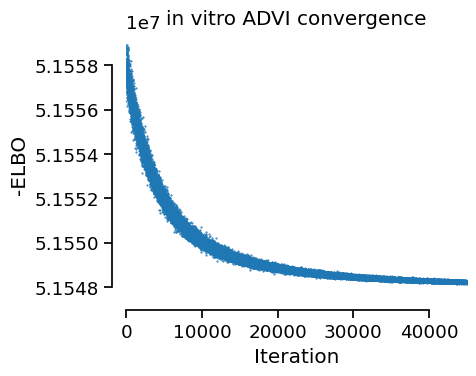

In [54]:
traces_none = run_BayesInf_v(BIOMD64, data, n_samp=3)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 16,413


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,384.9


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 17,328


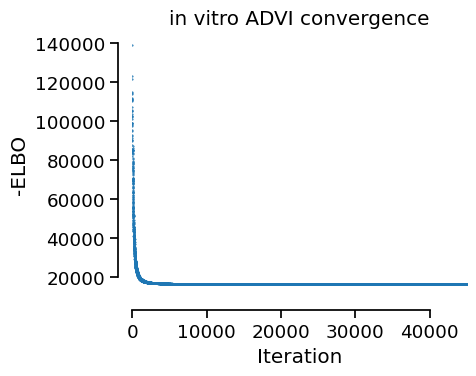

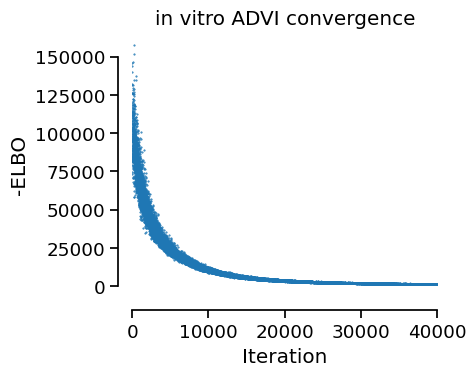

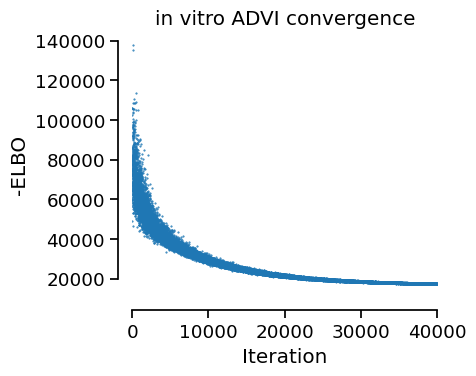

In [55]:
traces_xy = run_BayesInf_xy(BIOMD64_xy, omit_xy_data, n_samp=3)
traces_ex = run_BayesInf_ex(BIOMD64_ex, omit_ex_data, n_samp=3)
traces_ey = run_BayesInf_ey(BIOMD64_ey, omit_ey_data, n_samp=3)

## Plotting traces

In [56]:
Ex_0_none = (traces_none[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1_none = (traces_none[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2_none = (traces_none[2]['posterior']['Ex']).to_numpy().squeeze()
Ex_none = np.concatenate([Ex_0_none, Ex_1_none, Ex_2_none])
med_Ex_none = np.median(Ex_none, axis=0)

Ex_0_ex = (traces_ex[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1_ex = (traces_ex[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2_ex = (traces_ex[2]['posterior']['Ex']).to_numpy().squeeze()
Ex_ex = np.concatenate([Ex_0_ex, Ex_1_ex, Ex_2_ex])
med_Ex_ex = np.median(Ex_ex, axis=0)

Ex_0_xy = (traces_xy[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1_xy = (traces_xy[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2_xy = (traces_xy[2]['posterior']['Ex']).to_numpy().squeeze()
Ex_xy = np.concatenate([Ex_0_xy, Ex_1_xy, Ex_2_xy])
med_Ex_xy = np.median(Ex_xy, axis=0)

Ex_0_ey = (traces_ey[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1_ey = (traces_ey[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2_ey = (traces_ey[2]['posterior']['Ex']).to_numpy().squeeze()
Ex_ey = np.concatenate([Ex_0_ey, Ex_1_ey, Ex_2_ey])
med_Ex_ey = np.median(Ex_ey, axis=0)

## Plotting MCC and FCC comparisons

In [57]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [58]:
ex_et_0 = (traces_ex[0]['posterior']['e_t']).to_numpy().squeeze()
ex_et_1 = (traces_ex[1]['posterior']['e_t']).to_numpy().squeeze()
ex_et_2 = (traces_ex[2]['posterior']['e_t']).to_numpy().squeeze()
ex_et = np.concatenate([ex_et_0, ex_et_1, ex_et_2])
med_ex_et = np.median(ex_et, axis=0)

ey_et_0 = (traces_ey[0]['posterior']['e_t']).to_numpy().squeeze()
ey_et_1 = (traces_ey[1]['posterior']['e_t']).to_numpy().squeeze()
ey_et_2 = (traces_ey[2]['posterior']['e_t']).to_numpy().squeeze()
ey_et = np.concatenate([ey_et_0, ey_et_1, ey_et_2])
med_ey_et = np.median(ey_et, axis=0)

In [59]:
def estimate_CCs(BMCA_obj, Ex, en=None):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    if en is not None: 
        a = np.diag(en.T/ BMCA_obj.vn.values)
    else:
        a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(Ex.shape[0], axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(Ex.shape[0], axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(Ex.shape[0], axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


### Negative predictions

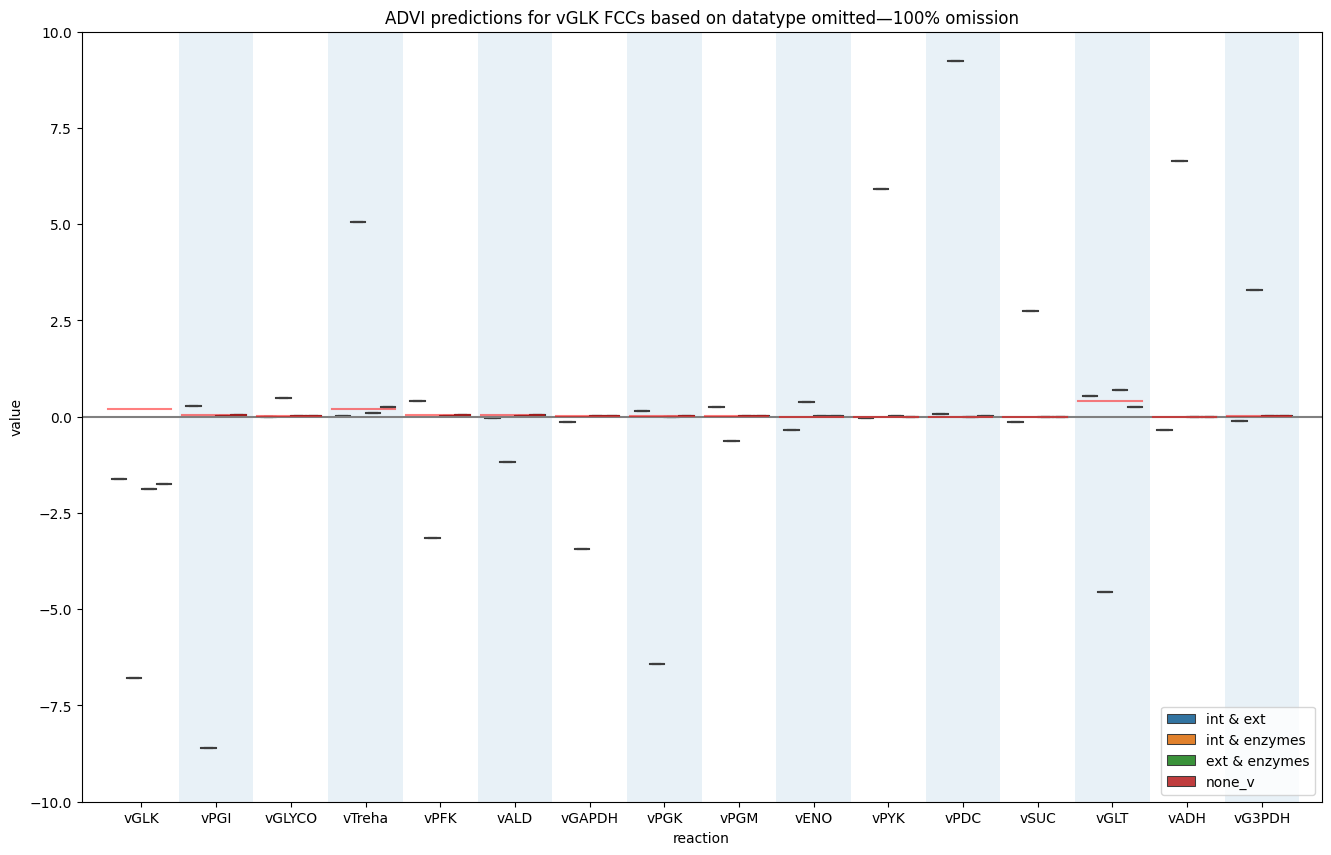

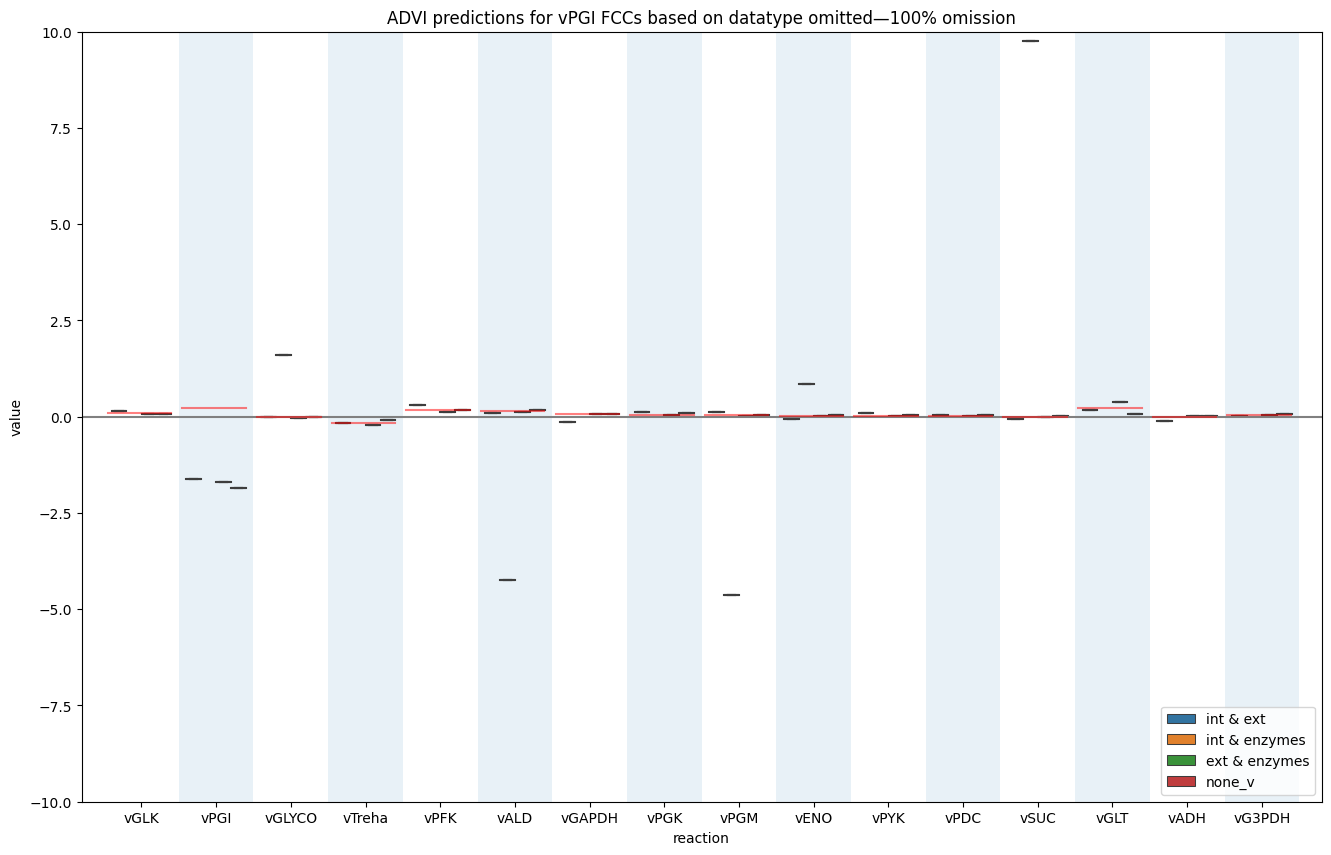

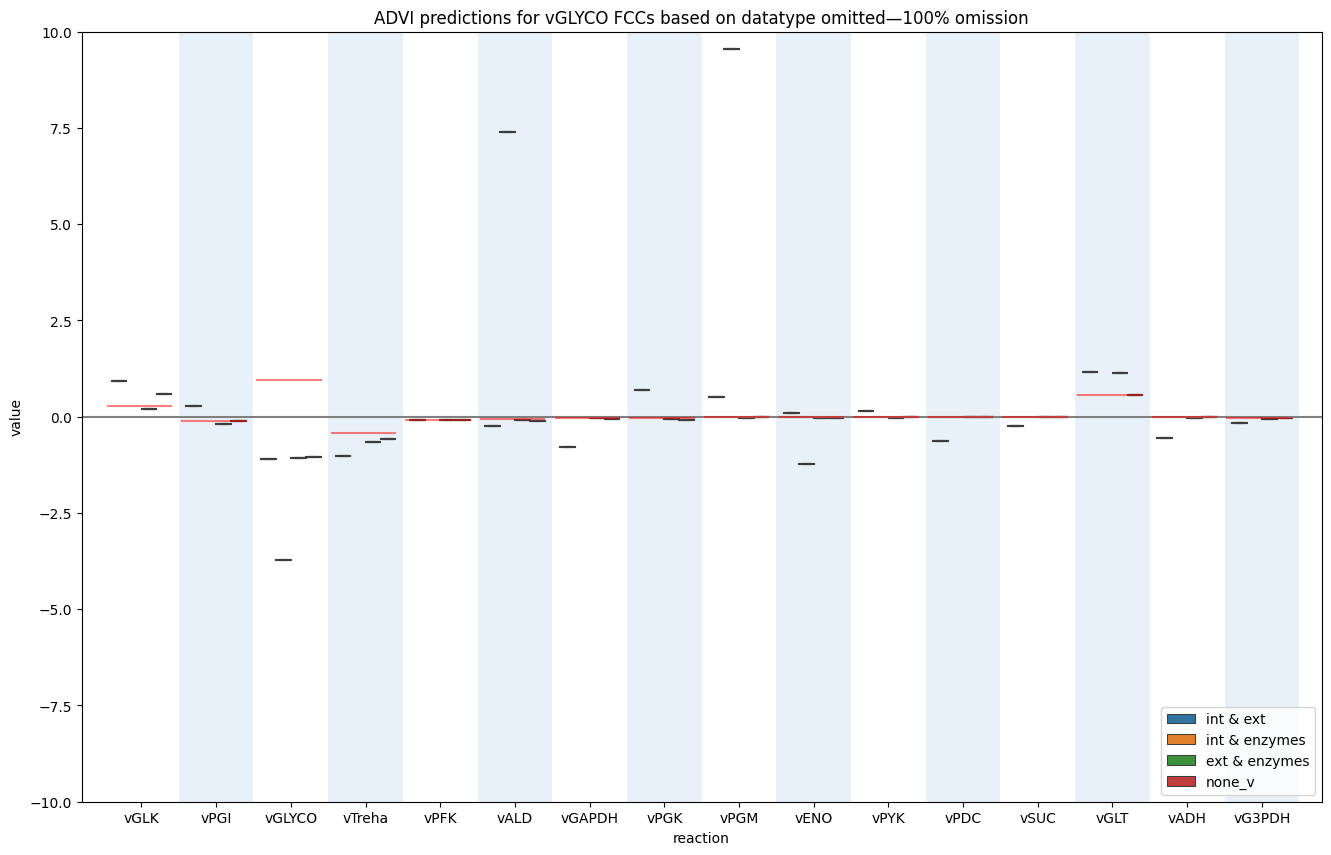

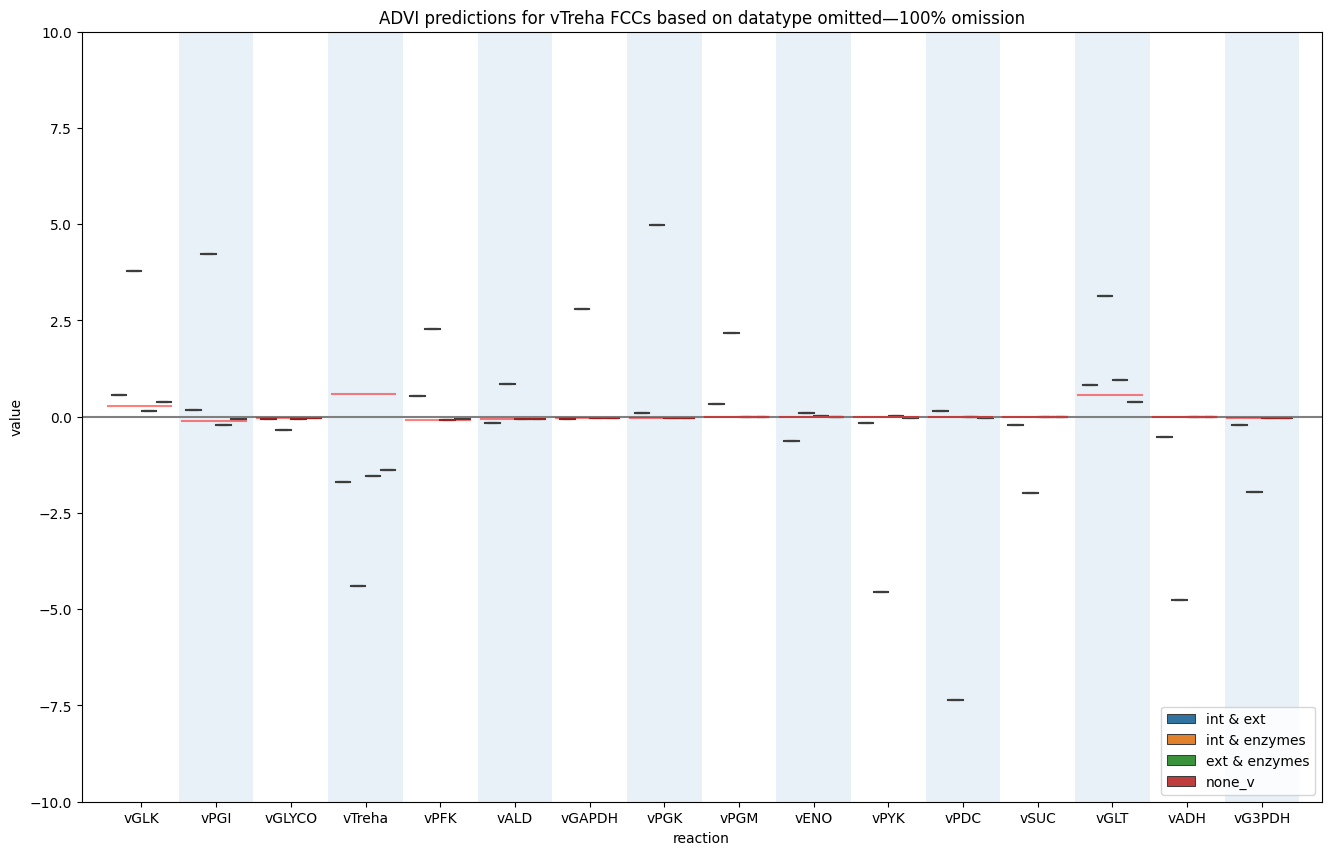

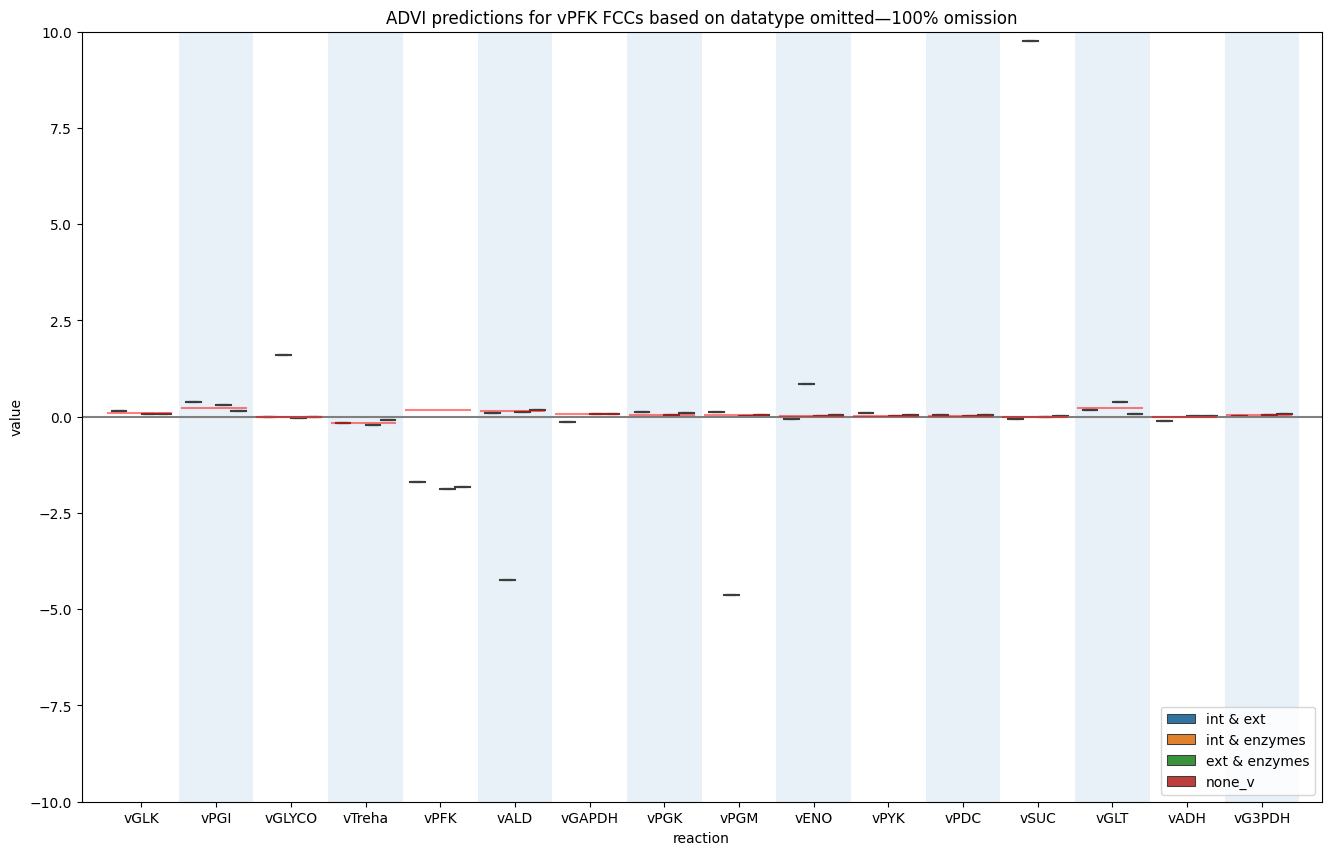

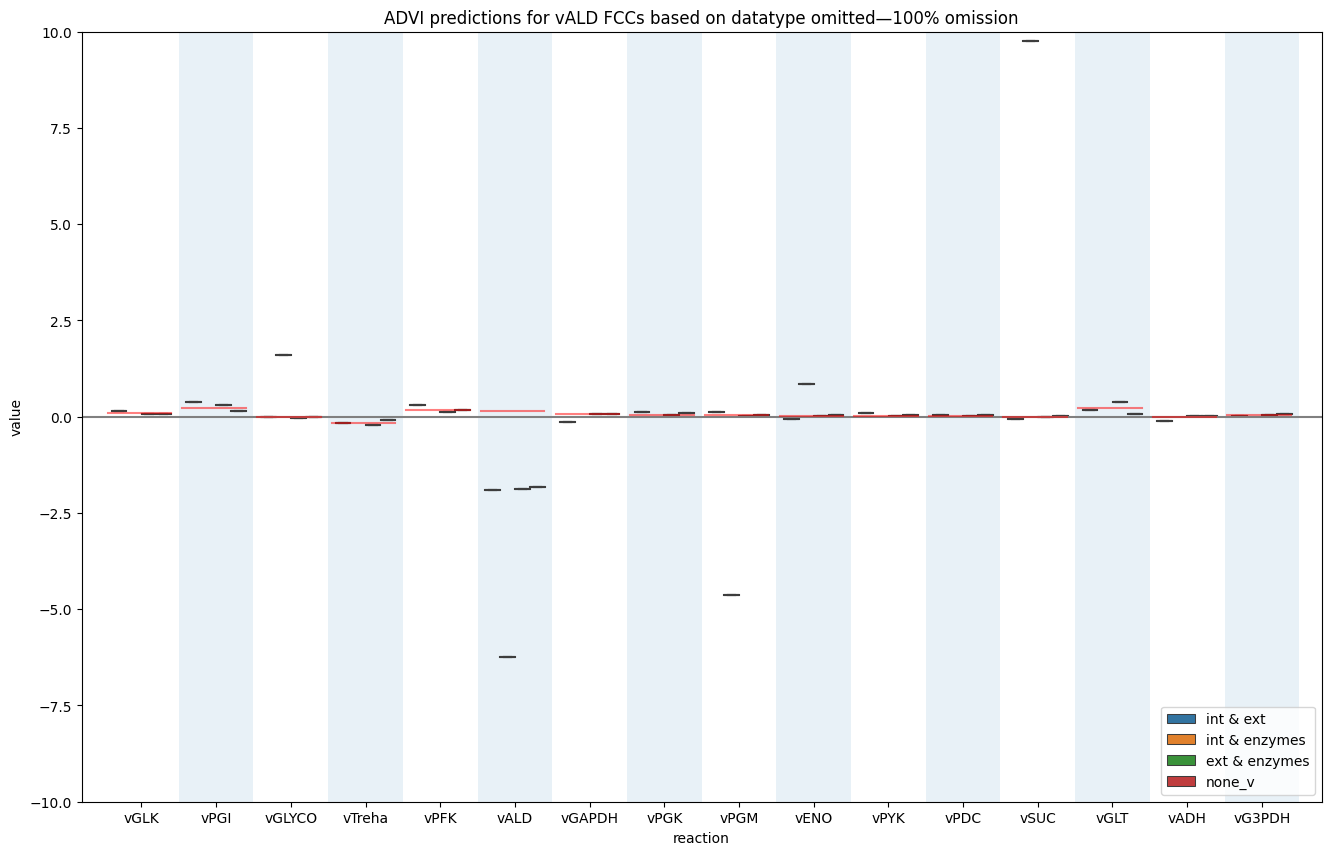

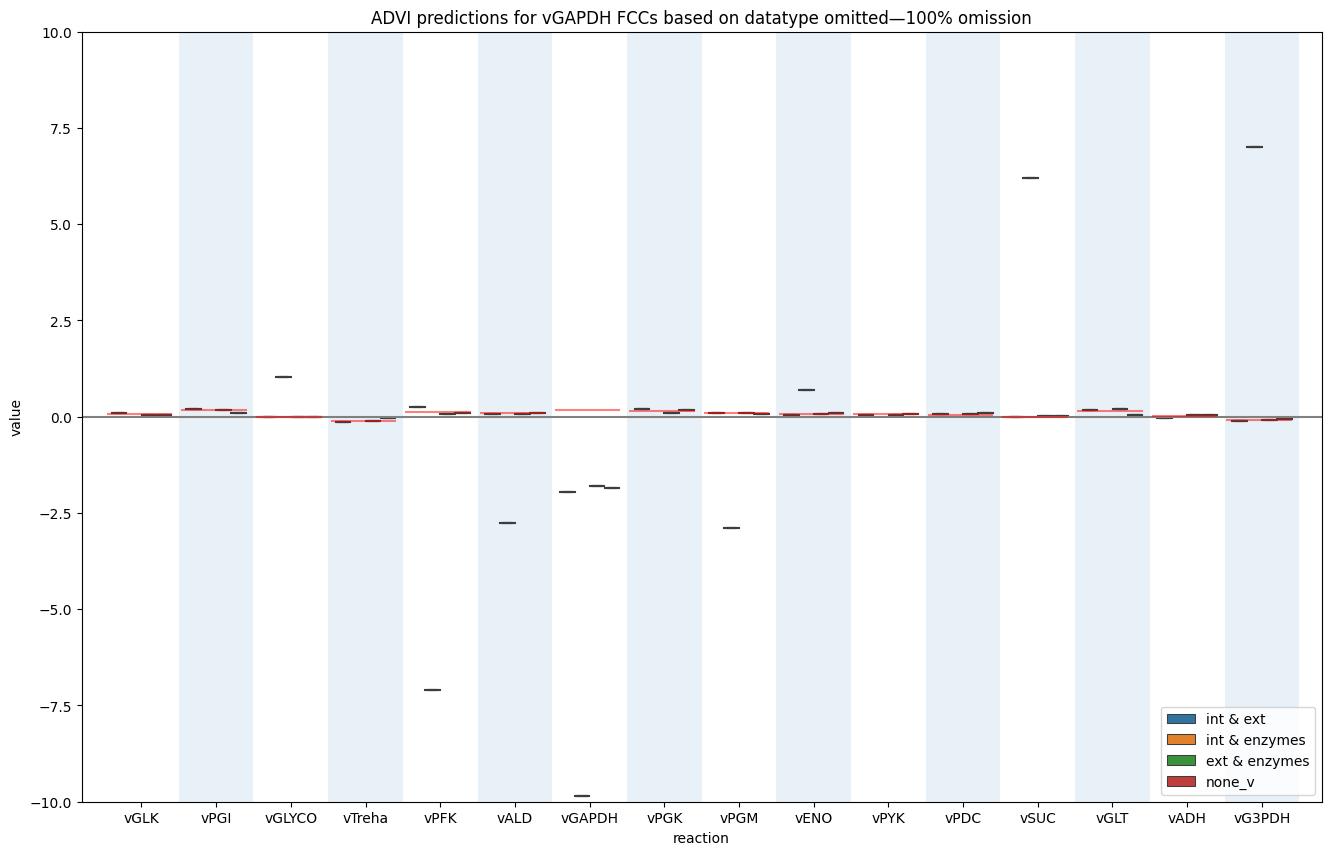

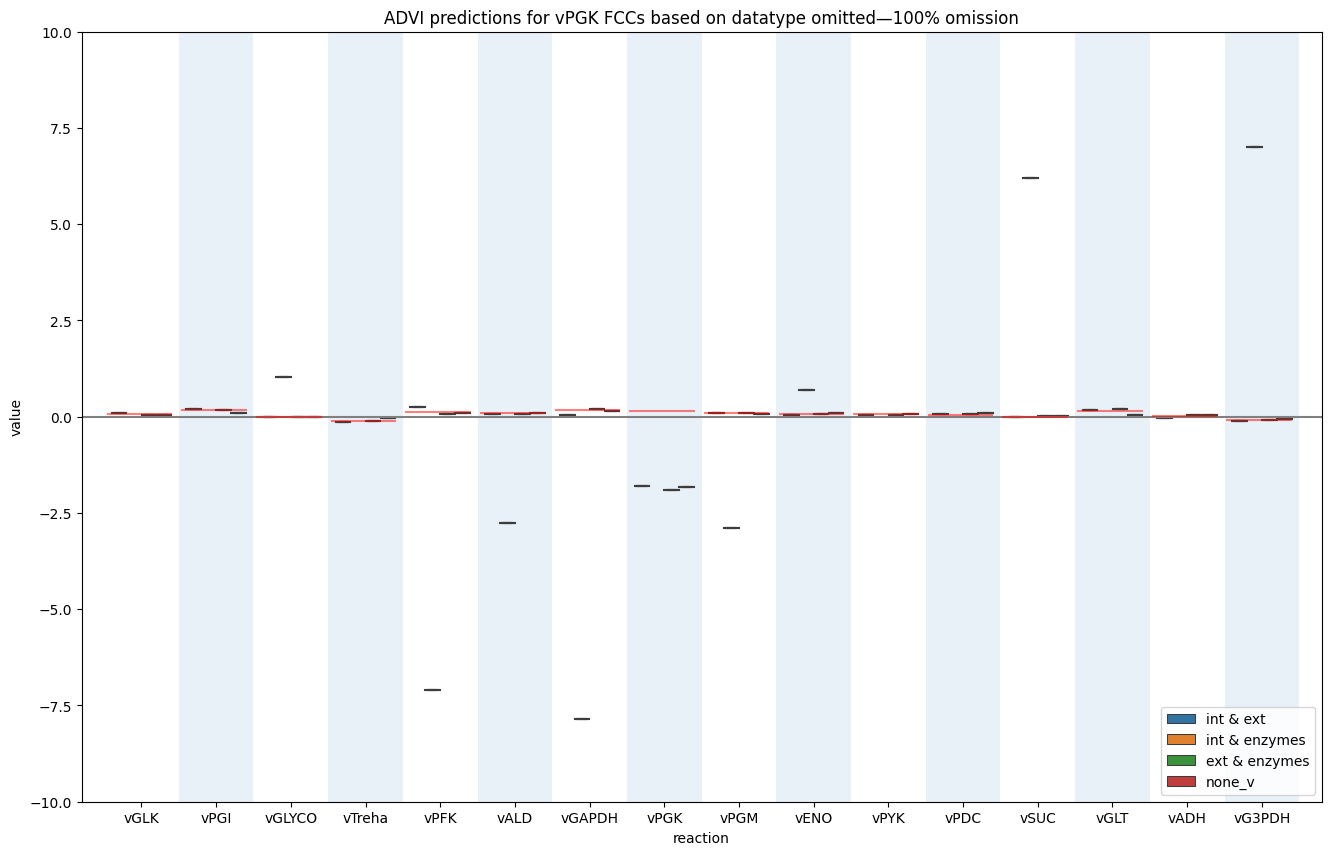

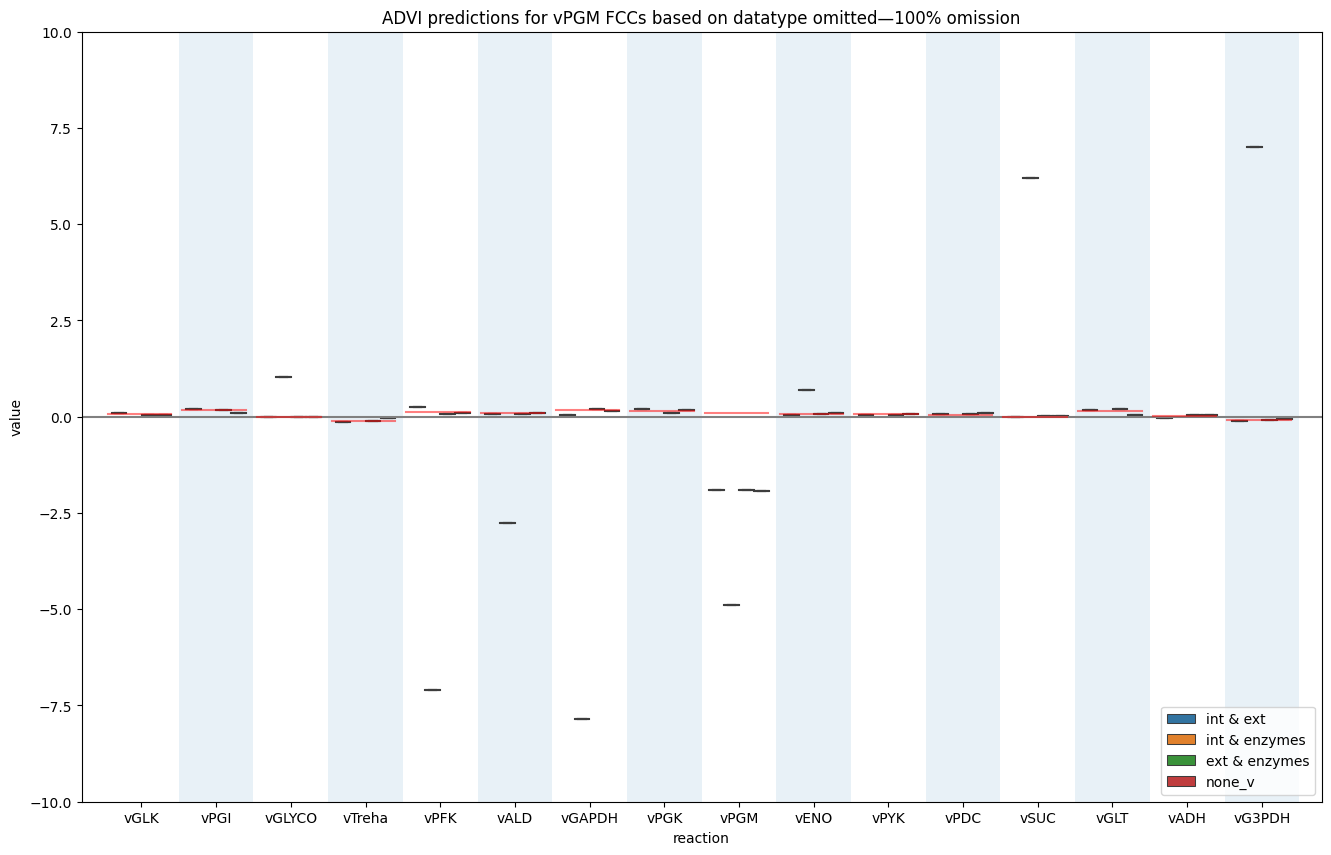

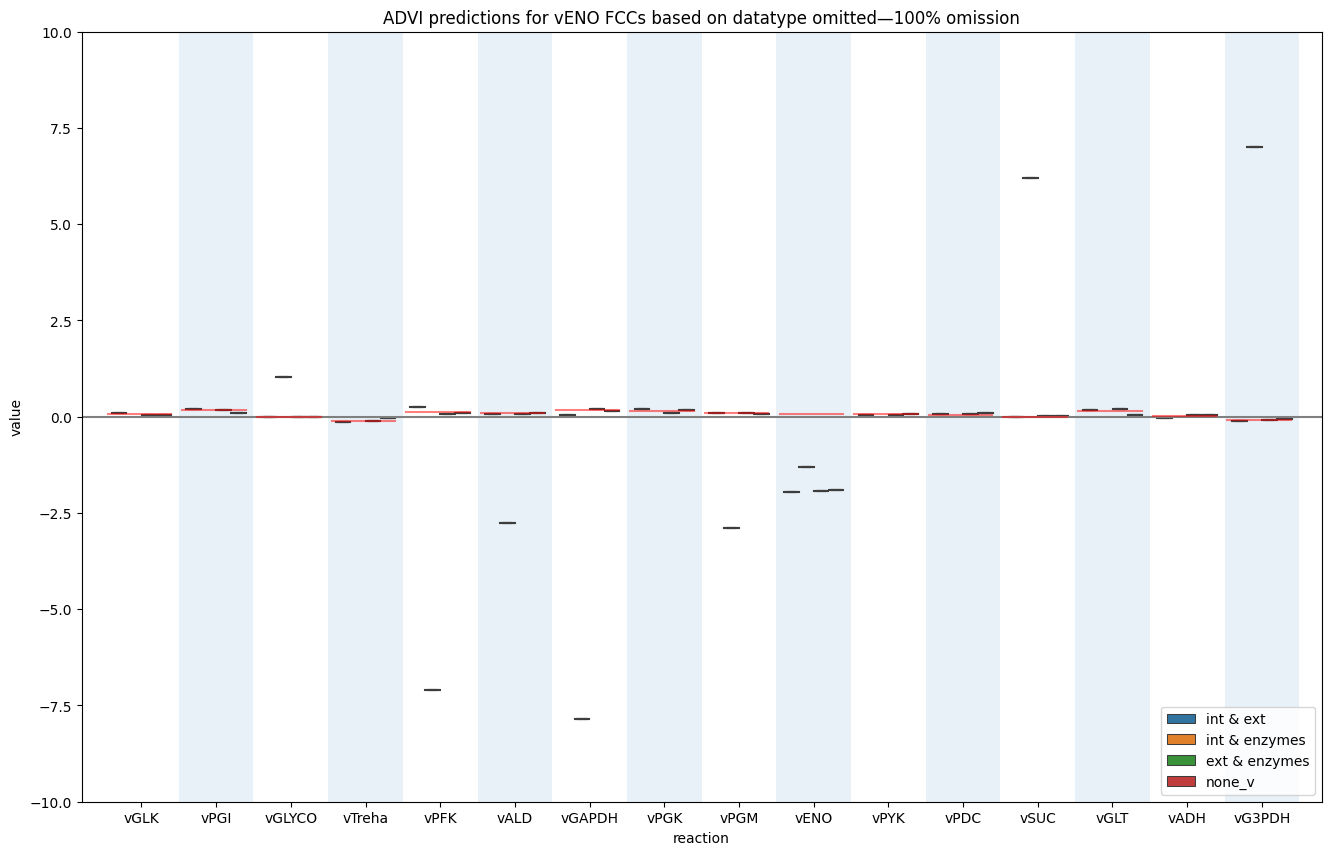

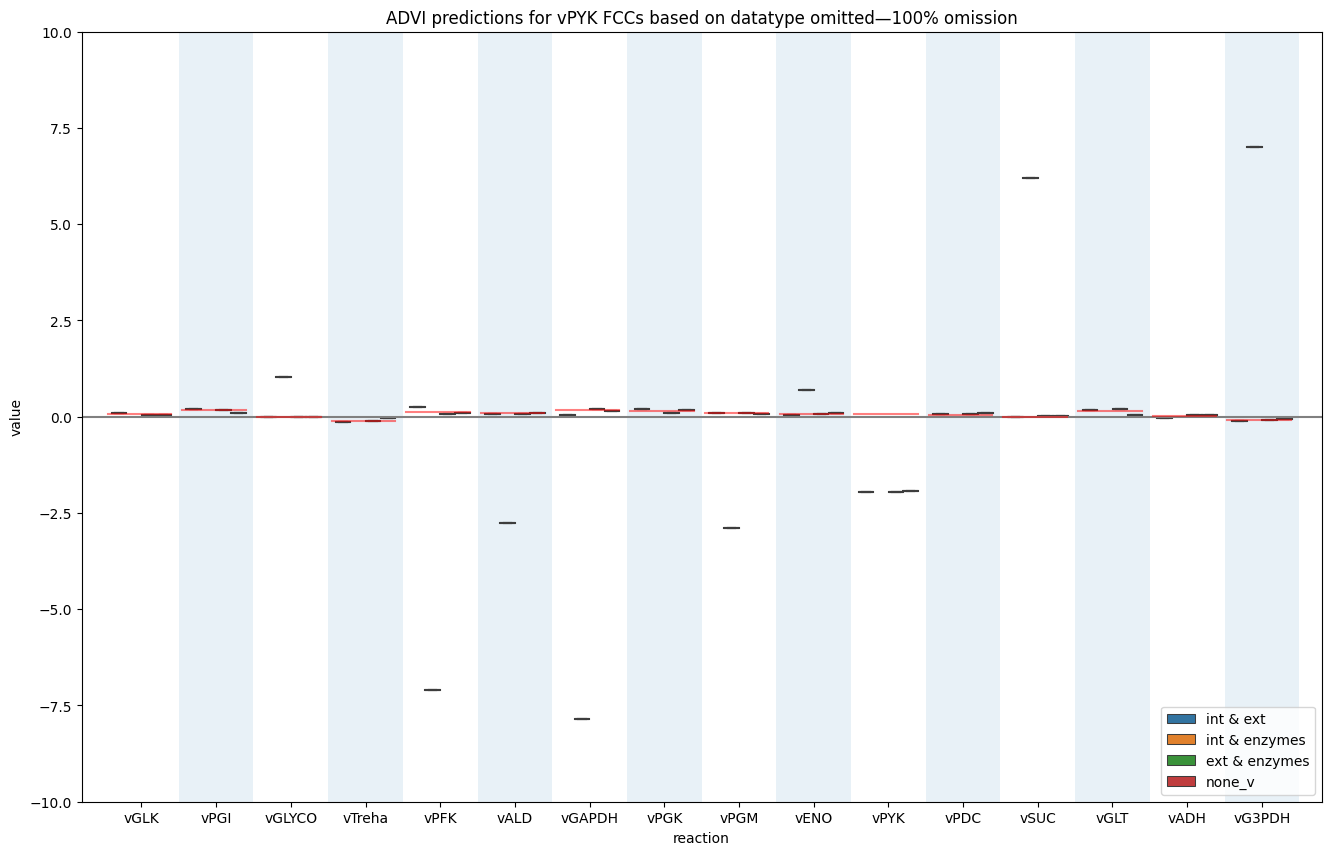

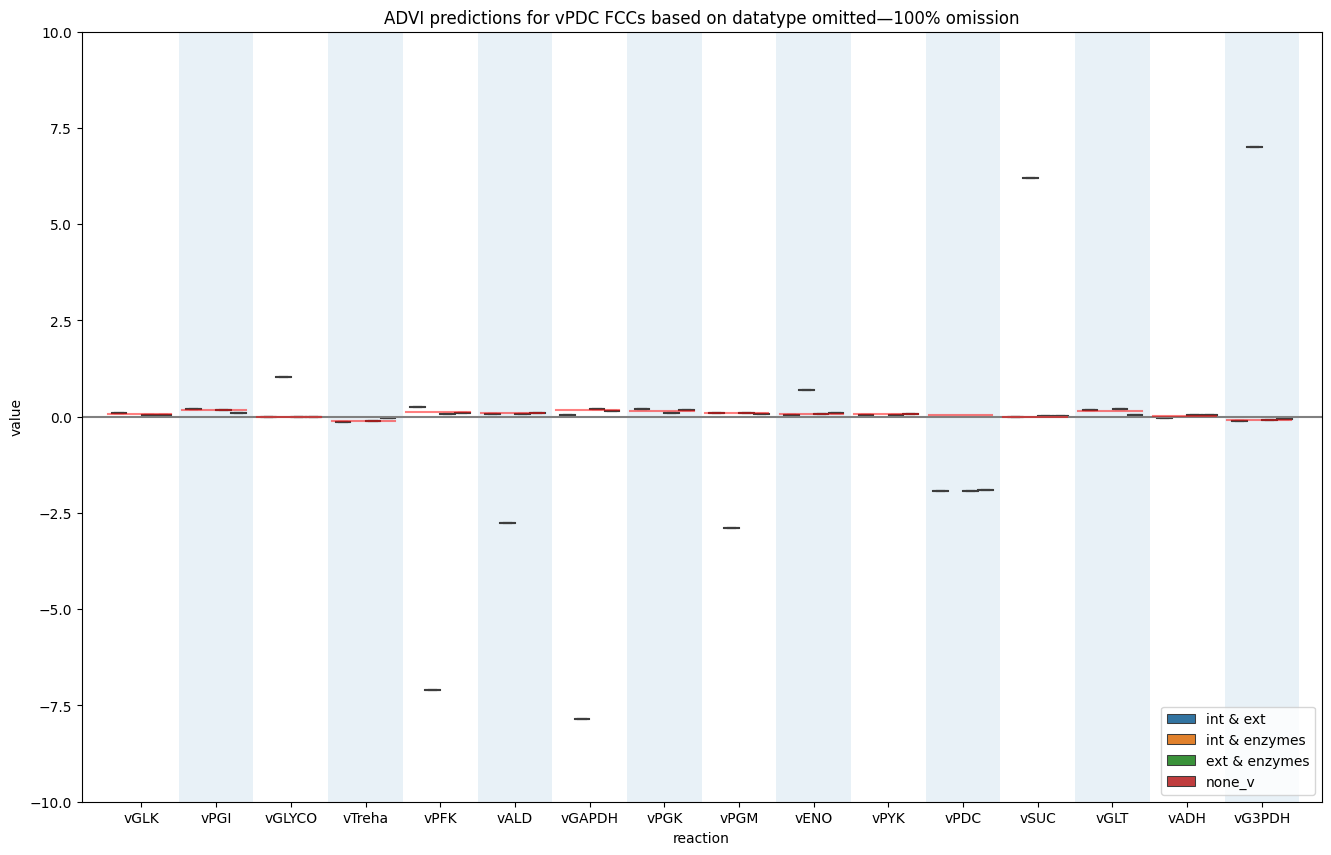

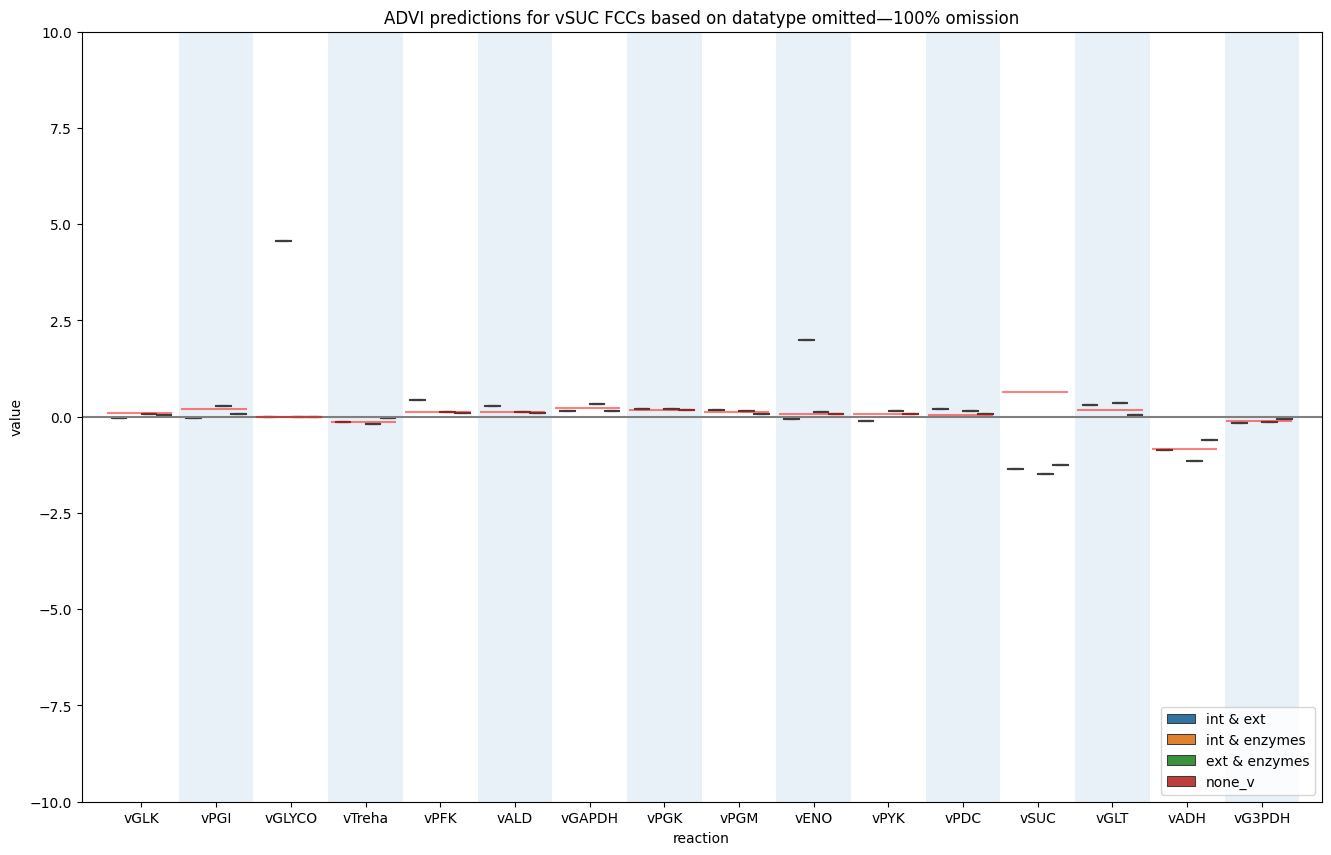

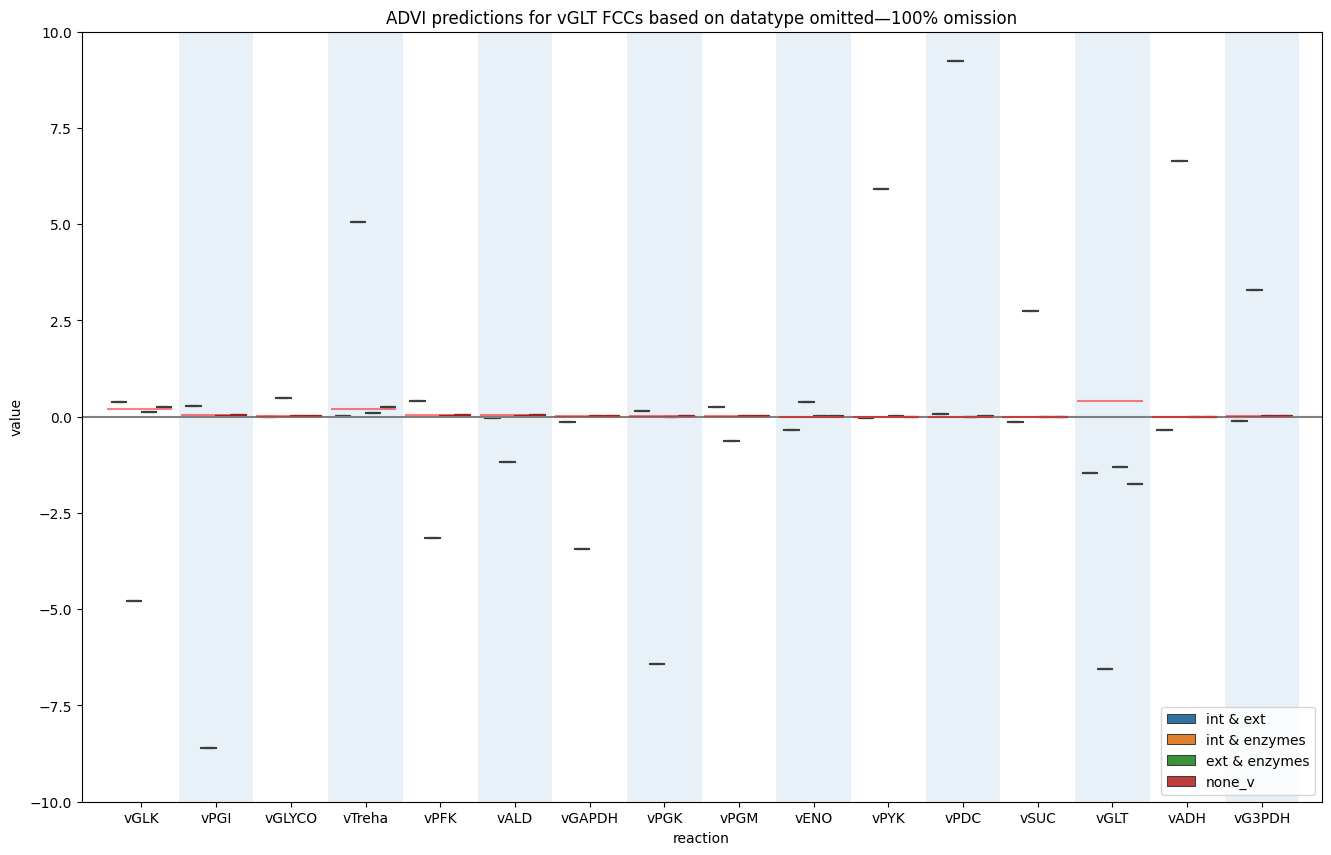

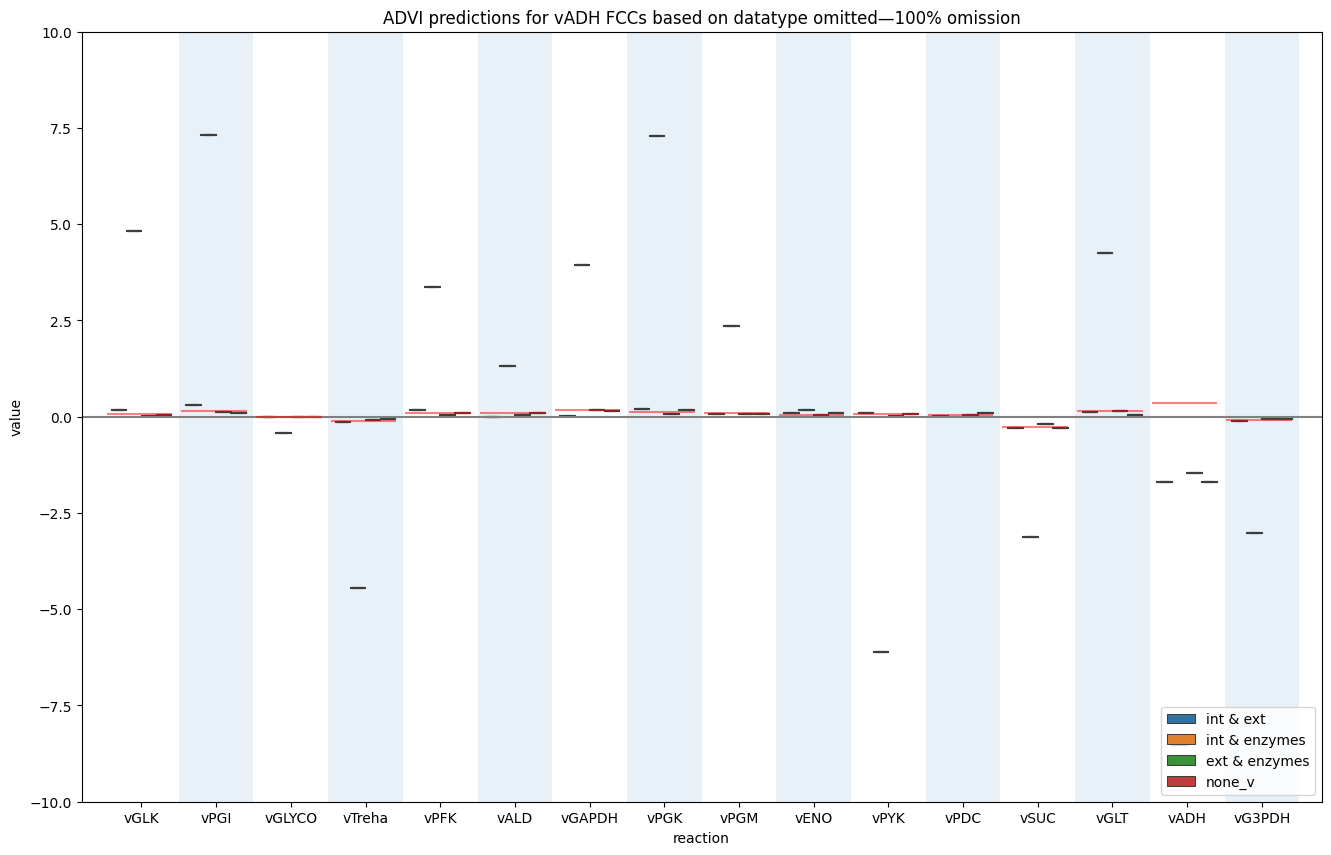

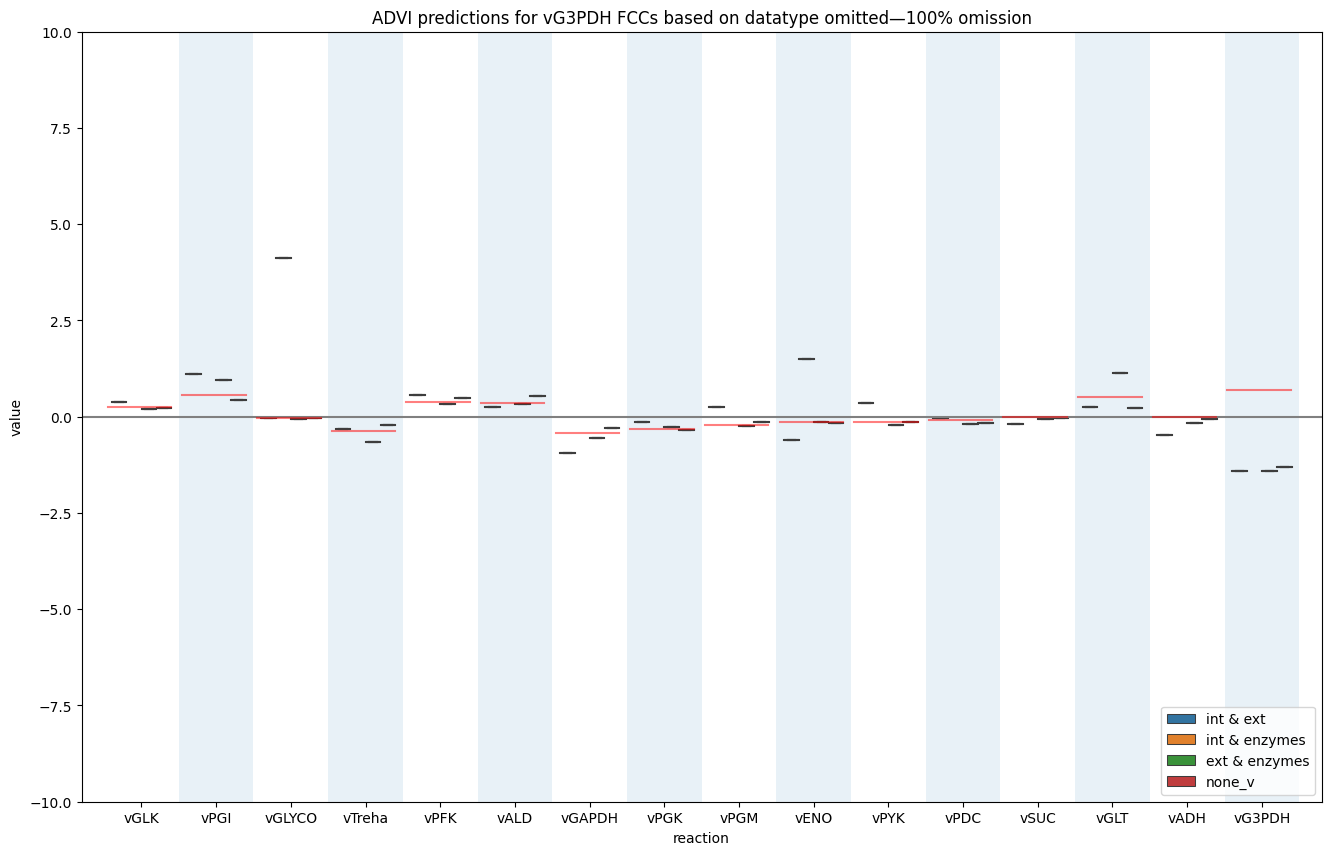

In [62]:
n_rxns = len(r.getReactionIds())

def append_FCC_df(postFCC, label):
    df = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    df['label']=[label]*len(df)
    return df 

for i, rxn in enumerate(r.getReactionIds()): 
    rxn_FCCs = []
    
    postCCC, postFCC = estimate_CCs(BIOMD64_xy, med_Ex_xy)
    rxn_FCCs.append(append_FCC_df(postFCC, 'int & ext'))
    postCCC, postFCC = estimate_CCs(BIOMD64_ex, med_Ex_ex, en=med_ex_et)
    rxn_FCCs.append(append_FCC_df(postFCC, 'int & enzymes'))
    postCCC, postFCC = estimate_CCs(BIOMD64_ey, med_Ex_ey, en=med_ey_et)
    rxn_FCCs.append(append_FCC_df(postFCC, 'ext & enzymes'))

    postCCC, postFCC = estimate_CCs(BIOMD64, med_Ex_none)
    rxn_FCCs.append(append_FCC_df(postFCC, 'none_v'))

    prd_FCCs = pd.concat(rxn_FCCs)

    sns_df = pd.DataFrame(prd_FCCs.loc[:, prd_FCCs.columns != 'label'].unstack())
    sns_df['label'] = list(prd_FCCs['label']) * n_rxns

    sns_df = sns_df.reset_index()
    sns_df = sns_df.drop('level_1', axis=1) # could also probably drop 'index'?
    sns_df.columns = ['reaction', 'value', 'label']
    
    fig = plt.figure(figsize=(16, 10))

    # change the outlier markers to smaller pinpoints
    flierprops = dict(markerfacecolor='0.75', markersize=2,
                linestyle='none')
    sns.boxplot(data=sns_df, x="reaction", y="value", hue='label', flierprops=flierprops, zorder=1) # , gap=.1

    # add in ground truth lines
    for i,val in enumerate(gtFCC.loc[rxn]): # .sort_index()
            plt.axhline(y = val, xmin = (0.021 + 0.0027*i) + (i*0.92)/n_rxns, xmax = (0.021 + 0.0027*i) + (i*0.92 + 0.82)/n_rxns, c='red', zorder=10, alpha=0.5)

    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)

    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')

    plt.title(f'ADVI predictions for {rxn} FCCs based on datatype omitted—100% omission')